# Exploring RtGender

In [1]:
# import things
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from scipy import stats

In [2]:
# set corpus directory
root = "/Users/katie/Documents/Data_Science/Gendered-Interaction-Online/private/rtgender/"

fb_congress_posts = pd.read_csv(root + 'facebook_congress_posts.csv')
print(fb_congress_posts.shape)
fb_congress_posts.head()

(548341, 5)


,op_id,op_gender,post_id,post_text,post_type
0,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video
1,57265377,M,1,Roses are red...and so is Texas. Let's keep it...,video
2,57265377,M,2,#TBT to this classic video. #DonkeyWhisperer,video
3,57265377,M,3,Since President Donald J. Trump was sworn in o...,video
4,57265377,M,4,Remembering our 40th president today. LIKE to ...,video


In [3]:
fb_congress_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548341 entries, 0 to 548340
Data columns (total 5 columns):
op_id        548341 non-null int64
op_gender    548341 non-null object
post_id      548341 non-null int64
post_text    510135 non-null object
post_type    548341 non-null object
dtypes: int64(2), object(3)
memory usage: 20.9+ MB


There are some null values in post_text... let's take a look.

In [4]:
null_posts = fb_congress_posts[fb_congress_posts.post_text.isnull()]
null_posts.head()

,op_id,op_gender,post_id,post_text,post_type
27,57265377,M,27,NaN,video
55,57265377,M,55,NaN,photo
91,57265377,M,91,NaN,photo
95,57265377,M,95,NaN,link
128,57265377,M,128,NaN,photo


What kind of post types are there no text involved?

In [5]:
null_posts.post_type.value_counts()

link      17085
photo     15526
video      3734
event      1766
note         43
status       31
music        21
Name: post_type, dtype: int64

In [6]:
null_posts[null_posts.post_type == 'status'].sample()

,op_id,op_gender,post_id,post_text,post_type
62039,14017754,M,62039,NaN,status


Hm... how do you post an empty status? Not really sure. But this pretty much gives us no information, except for the gender of the original poster.

Anyways, let's replace the null values with an empty string.

In [7]:
fb_congress_posts.post_text.fillna('', inplace=True)
fb_congress_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548341 entries, 0 to 548340
Data columns (total 5 columns):
op_id        548341 non-null int64
op_gender    548341 non-null object
post_id      548341 non-null int64
post_text    548341 non-null object
post_type    548341 non-null object
dtypes: int64(2), object(3)
memory usage: 20.9+ MB


Yay, looks good.

How many unique posters are there?

In [8]:
fb_congress_posts.op_id.value_counts()

61839194    4853
18876566    4846
29687946    4108
36875843    4040
50863205    3939
42989017    3855
66658382    3837
95597578    3795
10532564    3681
79121728    3659
42443414    3599
44866489    3531
70760728    3466
91600525    3430
347502      3401
73726010    3371
63776107    3299
40220308    3297
32185537    3276
83432188    3164
60329137    3140
50909248    3125
72264613    3119
23706532    3108
56883970    3015
73169587    2990
77914417    2960
71417411    2924
4584091     2902
8879946     2900
            ... 
54086639     173
61999298     169
39491026     133
43061204     112
96418867     100
12142782      95
86681682      89
84331141      87
87147344      86
3812062       83
64875568      81
85181735      80
98364166      79
64366485      72
20975602      63
76269753      59
74629159      58
86585451      55
54661425      52
87791089      51
15741954      46
41427210      45
11268555      38
74761634      31
25231270      28
45584113      17
78379937      15
44683265      

In [9]:
fb_congress_posts.op_id.nunique()

407

Let's see male vs. female posters... It'd be nice if it were about even.

In [10]:
fb_congress_posts.op_gender.value_counts()

M    413011
W    135330
Name: op_gender, dtype: int64

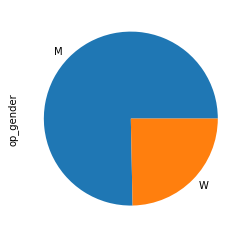

In [11]:
fb_congress_posts.op_gender.value_counts().plot(kind='pie')

Not as even as we might like to see...

Let's look at what type of posts there are too.

In [12]:
fb_congress_posts.post_type.value_counts()

link      210499
photo     199123
status     87921
video      46842
event       3417
music        278
note         261
Name: post_type, dtype: int64

That's the basics of the Facebook congress posts.

Let's now look at the corresponding response file:

In [13]:
fb_congress_responses = pd.read_csv(root + 'facebook_congress_responses.csv')
print(fb_congress_responses.shape)
fb_congress_responses.head()

(13866507, 7)


,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category
0,57265377,M,0,Jerry,Protecting birth is not the same as protecting...,Roger Williams,Congress_Republican
1,57265377,M,0,Andrea,You need to protect children and leave my body...,Roger Williams,Congress_Republican
2,57265377,M,0,Sherry,Thank you,Roger Williams,Congress_Republican
3,57265377,M,0,Bob,Thank you Roger,Roger Williams,Congress_Republican
4,57265377,M,0,Joy,Unwanted pregnancy is a sad and unfortunate si...,Roger Williams,Congress_Republican


Okay... so how is this set up? Looks like I should match this to the original poster from the first data frame by op_id and post_id. Also, this doesn't contain gender - but contains names. Can do something with that.

In [14]:
fb_congress_responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13866507 entries, 0 to 13866506
Data columns (total 7 columns):
op_id            int64
op_gender        object
post_id          int64
responder_id     object
response_text    object
op_name          object
op_category      object
dtypes: int64(2), object(5)
memory usage: 740.6+ MB


In [15]:
# look at categories of op
fb_congress_responses.op_category.value_counts()

Congress_Republican     8886650
Congress_Democratic     4786769
Congress_Independent     193088
Name: op_category, dtype: int64

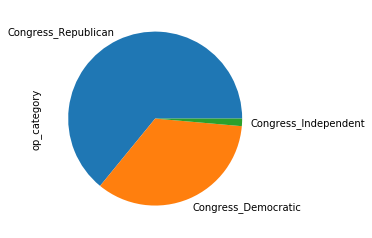

In [16]:
fb_congress_responses.op_category.value_counts().plot(kind='pie')

Mostly Republican posts, good amount of Democratic posts, and barely any Independent. Not sure how much this will impact my study, as I am primarily looking at gender and interaction between genders.

Let's see how many responses for the IDs...

In [17]:
fb_congress_responses.op_id.value_counts()

29687946    1293804
83458649     816417
46506154     632376
94031602     509791
95597578     498077
99469231     301337
53513040     234747
10174826     220292
39757514     212866
61839194     206575
18759563     192314
56371090     177483
85385501     175593
81592736     172578
65476274     166634
42138413     151895
86569077     150081
91600525     149529
60239508     148538
69918698     138155
83432188     136436
11077114     132133
87491774     131931
48284422     126863
7212873      124219
57265377     114580
76508222     110755
86386775     108080
65473098      99662
8266906       95934
             ...   
54661425        810
64875568        808
41098373        779
86681682        774
7840915         694
25231270        543
41427210        534
87147344        504
17310           498
86585451        497
12142782        483
39491026        452
85181735        422
98364166        399
37869252        391
62218886        382
30043764        375
20975602        359
180984          350


Looks like there are 402 unique IDs.

In [18]:
fb_congress_responses.op_id.nunique()

402

Hm... so there are 5 less than the posts. Does this mean 5 posters don't have responses? Something to further analyze later... (when we combine the posts and responses!)

For now, let's check out some other files.

In [19]:
fb_wiki_posts = pd.read_csv(root + 'facebook_wiki_posts.csv')
print(fb_wiki_posts.shape)
fb_wiki_posts.head()

(149448, 5)


,op_id,op_gender,post_id,post_text,post_type
0,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo
1,11679984,M,1,NaN,photo
2,11679984,M,2,Temps warming up for the holiday weekend! I wi...,photo
3,11679984,M,3,Showers heading this way ..,photo
4,11679984,M,4,Storm potential update...feel free to share th...,photo


In [20]:
fb_wiki_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149448 entries, 0 to 149447
Data columns (total 5 columns):
op_id        149448 non-null int64
op_gender    149448 non-null object
post_id      149448 non-null int64
post_text    133017 non-null object
post_type    149448 non-null object
dtypes: int64(2), object(3)
memory usage: 5.7+ MB


So we have some nulls... let's look.

In [27]:
null_wiki = fb_wiki_posts[fb_wiki_posts.post_text.isnull()]
null_wiki.head()

,op_id,op_gender,post_id,post_text,post_type
1,11679984,M,1,NaN,photo
5,11679984,M,5,NaN,video
14,11679984,M,14,NaN,video
19,11679984,M,19,NaN,video
26,11679984,M,26,NaN,video


In [28]:
# what kind of posts are null?
null_wiki.post_type.value_counts()

link      7307
photo     6994
video     1931
event      149
status      30
note        19
music        1
Name: post_type, dtype: int64

Again, mostly links, photos, and videos. So these were posted with no accompanying text.

In [29]:
# look at post types for the whole thing
fb_wiki_posts.post_type.value_counts()

photo     61411
link      37609
status    33495
video     16026
event       859
note         32
music        16
Name: post_type, dtype: int64

In [30]:
fb_wiki_posts.op_gender.value_counts()

W    99692
M    49756
Name: op_gender, dtype: int64

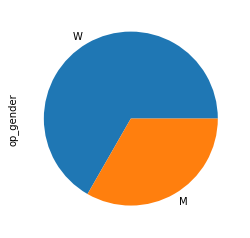

In [31]:
fb_wiki_posts.op_gender.value_counts().plot(kind='pie')

So this one actually has a lot more female than male posters. How many unique posters are there?

In [32]:
fb_wiki_posts.op_id.value_counts()

66833072    8446
40564507    7809
86899837    7463
98249750    6857
62514781    6170
12913141    5735
95717050    5586
22847849    5151
92735495    4900
30863532    4280
65335637    4011
5513521     3701
8009768     3411
84499674    3331
30328617    3159
21510115    2975
64889247    2695
5711509     2365
14149394    2350
75738195    2350
30174049    2302
50380881    2081
58282588    2027
90770262    1906
52814927    1817
73963222    1721
58317139    1654
56374656    1633
36013471    1570
82700793    1543
            ... 
63882247     211
86744690     205
38831413     196
34662643     188
81171619     183
5234181      175
21919722     172
70415190     151
17738392     146
21367951     141
62984185     118
58022699     112
70331604     109
17376695     101
97759749      84
57630420      83
11918400      73
221856        58
10073053      54
3359164       51
59979483      47
5523958       45
59949828      43
77326767      42
56211787      41
11049347      21
34901522      16
43015334      

In [33]:
fb_wiki_posts.op_id.nunique()

105

Now let's look at the corresponding response file.

In [34]:
fb_wiki_responses = pd.read_csv(root + 'facebook_wiki_responses.csv')
print(fb_wiki_responses.shape)
fb_wiki_responses.head()

(10667500, 7)


,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category
0,11679984,M,0,Michelle,Is this watch going to make it to LaPorte county?,Byron Miranda,Wikipedia_American_television_news_anchors
1,11679984,M,0,Melissa,Anything for Wilmington area,Byron Miranda,Wikipedia_American_television_news_anchors
2,11679984,M,0,Darlene,"Thanks, please keep us posted.",Byron Miranda,Wikipedia_American_television_news_anchors
3,11679984,M,0,Cheryl,Thanks Byron,Byron Miranda,Wikipedia_American_television_news_anchors
4,11679984,M,0,Melissa,[[STICKER]],Byron Miranda,Wikipedia_American_television_news_anchors


In [35]:
fb_wiki_responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10667500 entries, 0 to 10667499
Data columns (total 7 columns):
op_id            int64
op_gender        object
post_id          int64
responder_id     object
response_text    object
op_name          object
op_category      object
dtypes: int64(2), object(5)
memory usage: 569.7+ MB


Again, look at value counts for original poster and make sure it looks matched up.

In [36]:
fb_wiki_responses.op_id.value_counts()

95717050    1554417
66833072     758646
70331604     699847
92735495     682232
22847849     646658
59871832     556719
11139544     470412
21510115     439934
49470449     425541
58317139     335267
40564507     331120
36013471     295517
75738195     271862
65335637     261343
30863532     239733
84499674     224620
98249750     188368
62514781     188320
86899837     162085
82700793     161064
14149394     157724
5234181      144474
99847210     127078
66740241     108241
8009768       94014
12913141      81674
99348719      76669
77274779      73170
52814927      70252
73963222      66469
             ...   
97759749       1200
63882247       1054
43859861       1043
17376695       1009
71497803        957
17500695        812
3359164         729
221856          727
64933705        651
43015334        583
58282588        443
3282887         430
34662643        428
71302229        407
25681318        394
84963110        363
56211787        355
59979483        307
57630420        292


In [37]:
fb_wiki_responses.op_id.nunique()

105

Okay, so this time it matches.

Overall, both Facebook file pairs are formatted similarly, so this is relatively intuitive for processing. I think it would be a good idea to combine them in some way (put op information in the response file? That may seem like the easiest way).

Next, let's examine the format of the fitocracy files!

In [38]:
fit_posts = pd.read_csv(root + 'fitocracy_posts.csv')
print(fit_posts.shape)
fit_posts.head()

(318535, 4)


,op_id,op_gender,post_id,post_text
0,102,W,0,Thanks for the follow! I followed back :) I ...
1,104,W,1,I've decided I have this crazy goal of running...
2,104,W,2,"Umm, yeah, so those are assisted pull-ups. Bef..."
3,117,M,3,dam gurl lookin mad tone in dat pp holla bb
4,117,M,4,What's up there bear mode?


In [39]:
fit_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318535 entries, 0 to 318534
Data columns (total 4 columns):
op_id        318535 non-null int64
op_gender    318535 non-null object
post_id      318535 non-null int64
post_text    318535 non-null object
dtypes: int64(2), object(2)
memory usage: 9.7+ MB


Hooray - no nulls!

In [40]:
fit_posts.op_gender.value_counts()

M    173738
W    144797
Name: op_gender, dtype: int64

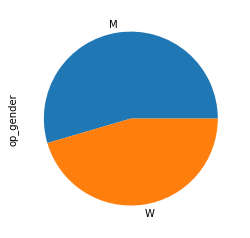

In [41]:
fit_posts.op_gender.value_counts().plot(kind='pie')

So this one is a lot closer to equal male vs. female posters.

In [42]:
fit_posts.op_id.value_counts()

400474     293
330199     272
1470475    260
152482     251
89636      245
1035972    229
1741536    207
815817     201
122603     198
459750     197
890201     194
388503     193
236376     191
1093027    191
46521      190
225333     189
1789805    189
288539     188
133039     187
586059     181
410588     180
330033     178
457987     173
772249     172
686374     170
691928     168
497913     167
510843     167
1221806    166
1389448    164
          ... 
395074       1
1482577      1
1478414      1
972632       1
978690       1
192223       1
991073       1
1007465      1
505716       1
1032053      1
1562488      1
1054592      1
915260       1
1582465      1
1421111      1
1388327      1
868133       1
309012       1
272134       1
278277       1
790275       1
1312514      1
1317345      1
1316608      1
777977       1
243444       1
233203       1
749295       1
202464       1
1445185      1
Name: op_id, Length: 99930, dtype: int64

This has a lot more unique posters though!

In [43]:
fit_posts.op_id.nunique()

99930

There's not really a lot more information included in this file, so let's look at the corresponding response file:

In [44]:
fit_responses = pd.read_csv(root + 'fitocracy_responses.csv')
print(fit_responses.shape)
fit_responses.head()

(318535, 6)


,op_id,op_gender,post_id,responder_id,response_text,responder_gender
0,102,W,0,1196122,One day at a time! =],M
1,104,W,1,5867,Crazy is synonymous with awesome in this case.,W
2,104,W,2,1635,You can enter assisted pullups. Select pullups...,M
3,117,M,3,8520,"Mirin 3% bodyfat? Yeah, you are.",W
4,117,M,4,29126,"Hey! I just started a new job, so things are s...",M


Yay - we finally have a responder gender! Let's see if they're listed for everyone?!

In [45]:
fit_responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318535 entries, 0 to 318534
Data columns (total 6 columns):
op_id               318535 non-null int64
op_gender           318535 non-null object
post_id             318535 non-null int64
responder_id        318535 non-null int64
response_text       318535 non-null object
responder_gender    318535 non-null object
dtypes: int64(3), object(3)
memory usage: 14.6+ MB


Wow... looks great.

Let's look at count of gender of responders:

In [46]:
fit_responses.responder_gender.value_counts()

W    163315
M    155220
Name: responder_gender, dtype: int64

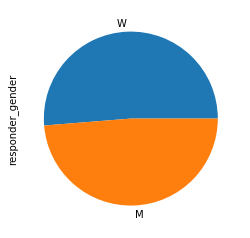

In [48]:
fit_responses.responder_gender.value_counts().plot(kind='pie')

Cool - this is pretty equal too!

Lastly, let's check unique op IDs:

In [49]:
fit_responses.op_id.value_counts()

400474     293
330199     272
1470475    260
152482     251
89636      245
1035972    229
1741536    207
815817     201
122603     198
459750     197
890201     194
388503     193
236376     191
1093027    191
46521      190
225333     189
1789805    189
288539     188
133039     187
586059     181
410588     180
330033     178
457987     173
772249     172
686374     170
691928     168
497913     167
510843     167
1221806    166
1389448    164
          ... 
395074       1
1482577      1
1478414      1
972632       1
978690       1
192223       1
991073       1
1007465      1
505716       1
1032053      1
1562488      1
1054592      1
915260       1
1582465      1
1421111      1
1388327      1
868133       1
309012       1
272134       1
278277       1
790275       1
1312514      1
1317345      1
1316608      1
777977       1
243444       1
233203       1
749295       1
202464       1
1445185      1
Name: op_id, Length: 99930, dtype: int64

Hm... so is there only one response per post? Something to further examine...

In [50]:
# post_id corresponds to id of original post
# if post_ids are all unique in the response file, this should indicate that there's only one response per post
fit_responses.post_id.nunique()

318535

This is the same number as the total number of rows! So, there is only one response per post. Maybe this is the format of the website.

Oh yeah, we can also check for unique responder IDs in this one.

In [51]:
fit_responses.responder_id.value_counts()

7715       46850
55233       2056
2           1703
138433      1446
30515       1177
423         1144
48152        919
1632002      880
762071       880
574324       805
769476       635
1264637      583
402367       544
202791       511
846800       502
11020        486
786107       479
591842       475
106217       457
1351285      441
488456       433
130842       425
126959       417
1181251      411
569952       408
153926       400
1341322      391
556615       389
180892       387
256771       387
           ...  
1044549        1
171058         1
1083562        1
30900          1
528569         1
633684         1
1004171        1
1132841        1
141566         1
1039002        1
143613         1
131323         1
449210         1
455359         1
330432         1
856771         1
1208565        1
803561         1
316155         1
708833         1
1250051        1
1276116        1
219344         1
783135         1
672553         1
152363         1
243916         1
1296578       

So certain people respond a LOT!

Again, with these files, it might be nice to put together the op information into the response file. It will feel much more unified.

Next, we'll move onto Reddit.

In [52]:
reddit_posts = pd.read_csv(root + 'reddit_posts.csv')
print(reddit_posts.shape)
reddit_posts.head()

(1453512, 6)


,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible
0,Kastoli,M,0,slayer task perhaps?,2007scape,False
1,Kastoli,M,1,"Black DHide legs, possibly an initiate pure?",2007scape,False
2,DCBizzle,M,2,Whats a tonk? lol,2007scape,False
3,ordona,M,3,Do the Stronghold of Security for a free 10k t...,2007scape,False
4,SlayerMaster,M,4,I cant tell if this guy just doesnt speak Engl...,2007scape,False


In [53]:
reddit_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453512 entries, 0 to 1453511
Data columns (total 6 columns):
op_id                1453512 non-null object
op_gender            1453512 non-null object
post_id              1453512 non-null int64
post_text            1453512 non-null object
subreddit            1453512 non-null object
op_gender_visible    1453512 non-null bool
dtypes: bool(1), int64(1), object(4)
memory usage: 56.8+ MB


Again - no nulls!

Interesting... a new category called op_gender_visible. I'll have to read into this, but I'm assuming this means whether or not their gender is visible to the responder. How often is it visible?

In [54]:
reddit_posts.op_gender_visible.value_counts()

False    1318037
True      135475
Name: op_gender_visible, dtype: int64

So assuming I'm interpreting it correctly, the gender is usually not visible to the poster. So for the ones that are false, this wouldn't be included in my GENDER x GENDER analysis, because the responder doesn't know what gender they are responding to. It can still be used in other parts of my analysis, though.

In [55]:
reddit_posts.op_gender.value_counts()

M    1148591
W     304921
Name: op_gender, dtype: int64

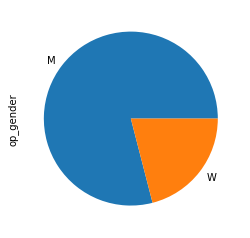

In [56]:
reddit_posts.op_gender.value_counts().plot(kind='pie')

Way more male!

In [57]:
reddit_posts.op_id.value_counts()

Apostolate              4823
MrManicMarty            3605
ThereIsAThingForThat    3022
codeverity              2743
crowdedconfirm          2260
Osiris32                2095
Cdtco                   2044
xNicolex                1976
ExternalTangents        1940
argv_minus_one          1920
StabbyPants             1819
kingeryck               1815
Kelsig                  1689
latticusnon             1673
DreadfulRauw            1630
naryn                   1593
joethesaint             1565
Ajaxx6                  1512
Asks_Politely           1483
Atheist101              1447
I_Enjoy_Taffy           1432
TheExtremistModerate    1404
BitchinTechnology       1382
IIHURRlCANEII           1381
nickachu_               1372
Magnon                  1335
Herdnerfer              1305
UnholyDemigod           1264
silverionmox            1255
ABoutDeSouffle          1247
                        ... 
Panacea4316                1
delicateKetchup            1
VigmaZen                   1
syd_uh_knee   

In [58]:
reddit_posts.subreddit.value_counts()

AskReddit               344400
AskMen                  133920
politics                 46727
funny                    44761
pics                     42920
relationships            34809
AdviceAnimals            33965
worldnews                33571
todayilearned            32652
nba                      32242
gaming                   27855
news                     27225
nfl                      27194
videos                   26940
WTF                      26682
soccer                   22315
leagueoflegends          22151
CasualConversation       21517
movies                   20567
OkCupid                  18239
CFB                      16025
anime                    15254
europe                   15233
hockey                   14949
Fitness                  14909
teenagers                12809
pcmasterrace             11841
explainlikeimfive        11270
SquaredCircle            11249
technology               11244
                         ...  
xboxone                   2932
heroesof

I think the fact that the subreddit "AskMen" has the second highest value count has a lot to do with why there are way more male posters! Let's look at the dankmemes column just for fun...

In [59]:
reddit_posts[reddit_posts.subreddit == 'dankmemes'].head()

,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible
643510,lepruhkon,M,643510,u cant hav my upspooks,dankmemes,False
643511,Hot_Beef_Injection,M,643511,10/10 post,dankmemes,False
643512,Hot_Beef_Injection,M,643512,"No I was being serious, I thought it was great...",dankmemes,False
643513,CosmicPube,W,643513,Are you kidding me?,dankmemes,False
643514,Hot_Beef_Injection,M,643514,O shit here comes that froggo,dankmemes,False


That's the basics for the reddit posts file.

So, we move on to loop at the corresponding response file:

In [60]:
reddit_responses = pd.read_csv(root + 'reddit_responses.csv')
print(reddit_responses.shape)
reddit_responses.head()

(1453512, 8)


,op_id,op_gender,post_id,responder_id,response_text,subreddit,responder_gender,responder_gender_visible
0,Kastoli,M,0,Thunda_Storm,or low level. I mean hes wearing black armour ...,2007scape,NaN,unknown_gender
1,Kastoli,M,1,Thunda_Storm,So... Low level,2007scape,NaN,unknown_gender
2,DCBizzle,M,2,minixmatt,"<link> TONK, TONK",2007scape,NaN,unknown_gender
3,ordona,M,3,Namiweso,Thanks I forgot about that place! :),2007scape,NaN,unknown_gender
4,SlayerMaster,M,4,Quantization,Or hes just trolling.,2007scape,NaN,unknown_gender


In [61]:
reddit_responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453512 entries, 0 to 1453511
Data columns (total 8 columns):
op_id                       1453512 non-null object
op_gender                   1453512 non-null object
post_id                     1453512 non-null int64
responder_id                1453512 non-null object
response_text               1453512 non-null object
subreddit                   1453512 non-null object
responder_gender            133222 non-null object
responder_gender_visible    1453512 non-null object
dtypes: int64(1), object(7)
memory usage: 88.7+ MB


So the responder gender is only visible 133222 times. The rest of the data is not null.

In [62]:
reddit_responses.responder_gender.value_counts()

M    102530
W     30692
Name: responder_gender, dtype: int64

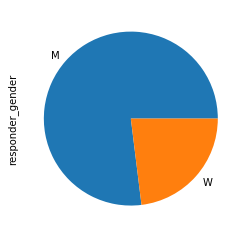

In [63]:
reddit_responses.responder_gender.value_counts().plot(kind='pie')

Again... a lot more male. I wonder how many of these responders were replying to a post where the gender of the poster is visible? Something to look at... This will be easier once the dataframes are combined though. Also, what kind of stuff is included in the responder_gender_visible column?

In [64]:
reddit_responses.responder_gender_visible.value_counts()

unknown_gender    1320290
True                78210
False               55012
Name: responder_gender_visible, dtype: int64

In [65]:
reddit_responses.op_id.value_counts()

Apostolate              4823
MrManicMarty            3605
ThereIsAThingForThat    3022
codeverity              2743
crowdedconfirm          2260
Osiris32                2095
Cdtco                   2044
xNicolex                1976
ExternalTangents        1940
argv_minus_one          1920
StabbyPants             1819
kingeryck               1815
Kelsig                  1689
latticusnon             1673
DreadfulRauw            1630
naryn                   1593
joethesaint             1565
Ajaxx6                  1512
Asks_Politely           1483
Atheist101              1447
I_Enjoy_Taffy           1432
TheExtremistModerate    1404
BitchinTechnology       1382
IIHURRlCANEII           1381
nickachu_               1372
Magnon                  1335
Herdnerfer              1305
UnholyDemigod           1264
silverionmox            1255
ABoutDeSouffle          1247
                        ... 
Panacea4316                1
delicateKetchup            1
VigmaZen                   1
syd_uh_knee   

Cool - this seems to be matched up with the post file.

Lastly, let's look at the TED response file:

In [66]:
ted_responses = pd.read_csv(root + 'ted_responses.csv')
print(ted_responses.shape)
ted_responses.head()

(190414, 5)


,op_id,op_gender,post_id,responder_id,response_text
0,Aimee Mullins,W,0,Laura,"She seems like a truly amazing person, regardl..."
1,Aimee Mullins,W,1,Ellen,"Aimee's true ""disability"" is when people treat..."
2,Aimee Mullins,W,2,Tanya,I love that she took away some of the mystery ...
3,Aimee Mullins,W,3,Salim,VERY inspiring indeed! I love these TED antiqu...
4,Aimee Mullins,W,4,Kiruba,We take running so much for granted that most ...


In [67]:
ted_responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190414 entries, 0 to 190413
Data columns (total 5 columns):
op_id            190347 non-null object
op_gender        190347 non-null object
post_id          190414 non-null int64
responder_id     190413 non-null object
response_text    190414 non-null object
dtypes: int64(1), object(4)
memory usage: 7.3+ MB


Okay so we have some nulls in op_id, op_gender, and just one from responder_id.

In [68]:
ted_responses.op_gender.value_counts()

M    144336
W     46011
Name: op_gender, dtype: int64

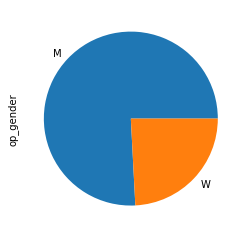

In [69]:
ted_responses.op_gender.value_counts().plot(kind='pie')

A lot more male.

Again, similar to the Facebook files, this doesn't contain the gender of the responder, only their name. We can run some sort of gender identifier on it though.

In [70]:
ted_responses.op_id.value_counts()

Ken Robinson                                                                                     3598
Richard Dawkins                                                                                  2651
Jill Bolte Taylor                                                                                1806
Amy Cuddy                                                                                        1481
Brené Brown                                                                                      1440
Simon Sinek                                                                                      1335
Hans Rosling                                                                                     1334
Elizabeth Gilbert                                                                                1285
Dan Dennett                                                                                      1130
Bill Gates                                                                        

What are these weird last ones? Let's replace the NaN values with an empty string for now, so we can take a look:

In [71]:
ted_responses.fillna('', inplace=True)
ted_responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190414 entries, 0 to 190413
Data columns (total 5 columns):
op_id            190414 non-null object
op_gender        190414 non-null object
post_id          190414 non-null int64
responder_id     190414 non-null object
response_text    190414 non-null object
dtypes: int64(1), object(4)
memory usage: 7.3+ MB


In [72]:
ted_responses[ted_responses.op_id.str.startswith('talks')]

,op_id,op_gender,post_id,responder_id,response_text
13018,"talks, TEDx, business, cities, collaboration, ...",,13018,1291,Rachel Botsman
167977,"talks, TEDx, business, creativity, culture, de...",,167977,1304,Jason Fried


Hm... don't really know what's going on here.

So that's the basics of the files. I really want to put them together (at least, the post/response pairs) to make it easier to see the relations between poster and responder. I think it would also be interesting to apply a name classifier on the facebook files and also do some sort of machine learning to attempt to classify the poster's gender.

Additionally, I can look at general differences between groups, as well as between genders and gender poster/responder pairs. I definitely need to do some reading up on sociolinguistics and the original report that goes along with this data set.

Oh yeah - I also wanted to take a quick look at the annotated file to see if I wanted to use it.

In [73]:
annotations = pd.read_csv(root + 'annotations.csv')
print(annotations.shape)
annotations.head()

(15352, 6)


,source,op_gender,post_text,response_text,sentiment,relevance
0,facebook_wiki,W,Stopped by Fashion Week and got to hang with A...,You are Both Sweet Ashley Tisdale and Lauren C...,Positive,Poster
1,facebook_wiki,M,"Well guys, real progress is happening. I'm 50 ...",Give us the first page to read. ONE PAGE.,Mixed,Content
2,facebook_wiki,W,Tonight is going to be a good night #PerfectMo...,this is my city was there 2 weeks a go,Neutral,Content
3,facebook_wiki,M,I know grandma Gilmore is real proud of you ht...,if grizzly Adams had a beard.,Neutral,Content
4,facebook_wiki,W,#NEWS to KNOW this AM - Mayor Emanuel will mak...,"Good morning Lourdes, have a great day! Great ...",Positive,Irrelevant


In [74]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15352 entries, 0 to 15351
Data columns (total 6 columns):
source           15352 non-null object
op_gender        15352 non-null object
post_text        15352 non-null object
response_text    15350 non-null object
sentiment        15352 non-null object
relevance        15352 non-null object
dtypes: object(6)
memory usage: 719.7+ KB


Only 2 nulls (in response text) - this is a very clean DataFrame since they made it to fit their specific needs. I'm not sure if I will use this, since it's specific to their project.

In [75]:
# look where these posts are from...
annotations.source.value_counts()

facebook_congress    4180
fitocracy            2904
facebook_wiki        2884
reddit               2732
ted                  2652
Name: source, dtype: int64

In [76]:
# look at genders
annotations.op_gender.value_counts()

M    7793
W    7559
Name: op_gender, dtype: int64

In [77]:
# look at types of sentiment
annotations.sentiment.value_counts()

Positive    7507
Neutral     3750
Negative    2539
Mixed       1556
Name: sentiment, dtype: int64

In [78]:
# what do they mean by mixed? Let's see
annotations[annotations.sentiment == 'Mixed'].head(10)

,source,op_gender,post_text,response_text,sentiment,relevance
1,facebook_wiki,M,"Well guys, real progress is happening. I'm 50 ...",Give us the first page to read. ONE PAGE.,Mixed,Content
29,facebook_wiki,W,"Welcome to the momma club, Vika!! A new world ...",Alle guten Wnsche an Mutter und Kind aus Deuts...,Mixed,Irrelevant
31,facebook_wiki,W,#maybeineedgas #justsayin,WGN must not pay very well.,Mixed,ContentPoster
79,facebook_wiki,M,No new #2brokegirls again tonight (all new nex...,I'll just take the original thanks,Mixed,Content
93,facebook_wiki,W,It's #MusicMonday and I am loving this song! S...,That means a lot coming from you....,Mixed,ContentPoster
99,facebook_wiki,M,Will Huckabee run in 2016? Here's what his dau...,The Democrats hope so!! Tear them GOP up!! haha!,Mixed,Content
110,facebook_wiki,M,Happy New Day from just outside the Time Warne...,I miss you on Good Morning America its not the...,Mixed,Poster
124,facebook_wiki,M,Walker Stalker convention in Atlanta,Ron T. Young they turned out good...I need the...,Mixed,Content
126,facebook_wiki,M,"Wow. A priest? Really? ALL SAINTS movie, Nashv...","Forgive me, Father for I have sinned.",Mixed,Content
129,facebook_wiki,W,Cover of the Miami Herald today! I may need to...,Maddison check this out!! www.h9water.com/CTH ...,Mixed,Irrelevant


In [79]:
annotations.iloc[124].response_text

'Ron T. Young they turned out good...I need them on a jpeg thing, my people did them for me at Staples but they missed a couple I wanted and my computer was trip pen and wouldnt allow me to save them'

In [80]:
# look at relevance
annotations.relevance.value_counts()

Content          8106
ContentPoster    3127
Poster           2316
Irrelevant       1803
Name: relevance, dtype: int64

Not really sure what the different categories mean here... Can further examine paper that goes along with this.

I at least understand the "irrelevant" category - let's take a look.

In [81]:
annotations[annotations.relevance == 'Irrelevant'].head()

,source,op_gender,post_text,response_text,sentiment,relevance
4,facebook_wiki,W,#NEWS to KNOW this AM - Mayor Emanuel will mak...,"Good morning Lourdes, have a great day! Great ...",Positive,Irrelevant
11,facebook_wiki,M,Anchoring New Day from Paris - it's been one y...,"Poor Chris, you look so jet lagged.",Neutral,Irrelevant
16,facebook_wiki,W,Best #makeup from the Golden Globes according ...,Just Click The Link https://youtu.be/ZD4jv21Gj...,Neutral,Irrelevant
29,facebook_wiki,W,"Welcome to the momma club, Vika!! A new world ...",Alle guten Wnsche an Mutter und Kind aus Deuts...,Mixed,Irrelevant
33,facebook_wiki,M,www.nextcontenders.com,big animal big idiot,Negative,Irrelevant


In [82]:
print('post:', annotations.iloc[4].post_text)
print()
print('response:', annotations.iloc[4].response_text)

post: #NEWS to KNOW this AM - Mayor Emanuel will make a special address today on police accountability...The third suspect in last month's #Paris attacks has been identified...#Teachers start voting today on a possible strike.

response: Good morning Lourdes, have a great day! Great Christmas card photo also!
